In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import pandas as pd
import random
from keras.models import load_model

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov 18 14:52:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Keras guide:

https://keras.io/guides/transfer_learning/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/KFolds mix_data/trein 1-2-3-5/'
valid_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/KFolds mix_data/4/'

In [ ]:
tf.io.gfile.listdir(data_dir)

['covid', 'dip', 'tuberculose', 'normais']

In [ ]:
image_shape = (224,224,3)
batch_size = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator()

In [ ]:
image_gen.flow_from_directory(data_dir)

Found 1350 images belonging to 4 classes.


# **Creating the model**

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense

In [ ]:
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.vgg19.preprocess_input(x)

vgg19 = tf.keras.applications.VGG19(input_tensor=x, input_shape = image_shape, include_top = False, weights="imagenet", pooling="avg")


80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the layers
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
z = vgg19.output
predictions = Dense(4, activation='softmax')(z)
model = Model(inputs=vgg19.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast (TFOpLambda)        (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (  (None, None, None, 3)     0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, None, None, 3)     0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

In [ ]:
model_checkpoint  = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/KFolds mix/model_checkpoint4',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    options=None,
    initial_value_threshold=None,
    verbose = 0
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
train_image_gen = image_gen.flow_from_directory(data_dir,
                                                #target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical'
                                                )

Found 1350 images belonging to 4 classes.


In [ ]:
validation_image_gen = image_gen.flow_from_directory(valid_dir,
                                                #target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical'
                                                )

Found 337 images belonging to 4 classes.


In [ ]:
train_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

# **Training the model**

In [ ]:
model.fit(train_image_gen,epochs=200,validation_data=validation_image_gen,callbacks=[early_stop,model_checkpoint,reduce_lr])

Epoch 1/200
43/43 [==============================] - 425s 10s/step - loss: 2.2734 - accuracy: 0.3437 - val_loss: 1.5551 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 2/200
43/43 [==============================] - 11s 253ms/step - loss: 1.1593 - accuracy: 0.5681 - val_loss: 1.1908 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 3/200
43/43 [==============================] - 11s 260ms/step - loss: 0.9380 - accuracy: 0.6563 - val_loss: 1.0780 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 4/200
43/43 [==============================] - 11s 243ms/step - loss: 0.8154 - accuracy: 0.7059 - val_loss: 1.0347 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 5/200
43/43 [==============================] - 11s 250ms/step - loss: 0.7370 - accuracy: 0.7385 - val_loss: 0.9372 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 6/200
43/43 [==============================] - 11s 255ms/step - loss: 0.6771 - accuracy: 0.7630 - val_loss: 0.8982 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 7/200
43/43 [==============================] - 11s 25

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

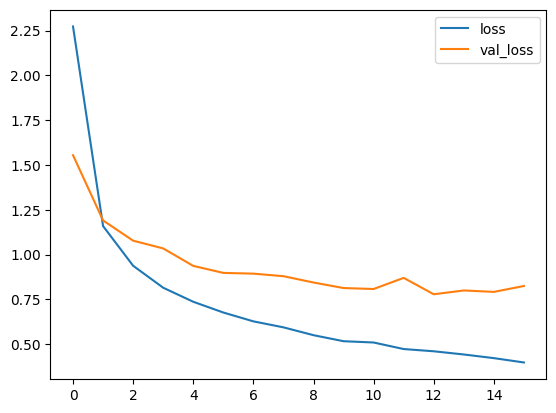

In [ ]:
losses[['loss','val_loss']].plot()

# **Fine tunning**

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/KFolds mix/model_checkpoint4')

In [ ]:
# Unfreeze all the layers
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
train_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

In [ ]:
model.fit(train_image_gen,epochs=10,validation_data=validation_image_gen,callbacks=[model_checkpoint])

Epoch 1/10
43/43 [==============================] - 49s 770ms/step - loss: 0.5544 - accuracy: 0.7993 - val_loss: 0.6640 - val_accuracy: 0.7715
Epoch 2/10
43/43 [==============================] - 33s 760ms/step - loss: 0.2722 - accuracy: 0.9111 - val_loss: 0.6198 - val_accuracy: 0.7982
Epoch 3/10
43/43 [==============================] - 32s 743ms/step - loss: 0.1386 - accuracy: 0.9615 - val_loss: 0.6450 - val_accuracy: 0.8160
Epoch 4/10
43/43 [==============================] - 33s 758ms/step - loss: 0.0666 - accuracy: 0.9815 - val_loss: 0.7085 - val_accuracy: 0.8249
Epoch 5/10
43/43 [==============================] - 32s 749ms/step - loss: 0.0179 - accuracy: 0.9993 - val_loss: 0.7680 - val_accuracy: 0.8398
Epoch 6/10
43/43 [==============================] - 32s 735ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.7863 - val_accuracy: 0.8249
Epoch 7/10
43/43 [==============================] - 32s 734ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.8287 - val_accuracy: 0.8309

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

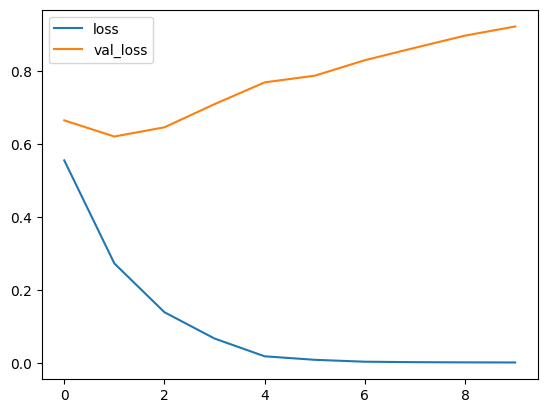

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/KFolds mix/model_checkpoint4')

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/VGG19_fine-tuning_avg_4_classes_mix_data_part1235.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
